# ARFS - regression

ARFS can be used for classification (binary or multi-class) and for regression. You just have to specify the right loss function.



In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import catboost
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from boruta import BorutaPy as bp
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path

import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.feature_selection import (
    MinRedundancyMaxRelevance,
    GrootCV,
    MissingValueThreshold,
    UniqueValuesThreshold,
    CollinearityThreshold,
    make_fs_summary,
)
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data

plt.style.use("fivethirtyeight")
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 1.0.7


In [3]:
%matplotlib inline

In [4]:
gc.enable()
gc.collect()

20

## Simple Usage
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.

## Leshy (Boruta evolution)

In [5]:
boston = load_data(name="Boston")
X, y = boston.data, boston.target

In [6]:
X.dtypes

CRIM             float64
ZN               float64
INDUS            float64
CHAS            category
NOX              float64
RM               float64
AGE              float64
DIS              float64
RAD             category
TAX              float64
PTRATIO          float64
B                float64
LSTAT            float64
random_num1      float64
random_num2        int32
random_cat      category
random_cat_2    category
genuine_num      float64
dtype: object

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,random_num1,random_num2,random_cat,random_cat_2,genuine_num
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.496714,0,cat_3517,Platist,7.080332
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,-0.138264,0,cat_2397,MarkZ,5.245384
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.647689,0,cat_3735,Dracula,6.375795
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1.523030,0,cat_2870,Bejita,6.725118
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,-0.234153,4,cat_1160,Variance,7.867781


In [8]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMRegressor(random_state=42, verbose=-1)

Native (impurity/Gini) feature importance, known to be biased.

Leshy iteration:  90%|█████████ | 9/10 [00:00<00:00, 11.01it/s]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:00.84
The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']
The agnostic ranking: [1 7 3 8 1 1 1 1 4 2 1 1 1 2 7 3 5 1]
The naive ranking: ['RM', 'genuine_num', 'LSTAT', 'CRIM', 'NOX', 'DIS', 'AGE', 'PTRATIO', 'B', 'TAX', 'random_num1', 'INDUS', 'random_cat', 'RAD', 'random_cat_2', 'random_num2', 'ZN', 'CHAS']


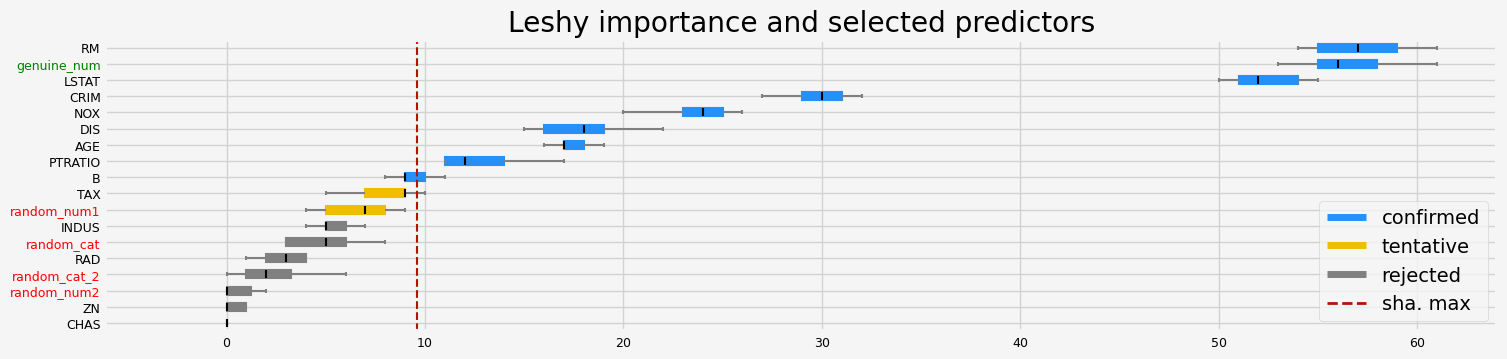

CPU times: user 3.04 s, sys: 238 ms, total: 3.28 s
Wall time: 1.47 s


In [9]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

SHAP importance

Leshy iteration:  90%|█████████ | 9/10 [00:00<00:00, 20.60it/s]




Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	8
All relevant predictors selected in 00:00:00.45
The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'random_num1'
 'genuine_num']
The agnostic ranking: [1 9 4 9 1 1 1 1 6 2 1 3 1 1 9 5 6 1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'PTRATIO', 'DIS', 'AGE', 'random_num1', 'NOX', 'TAX', 'B', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'random_num2', 'ZN', 'CHAS']


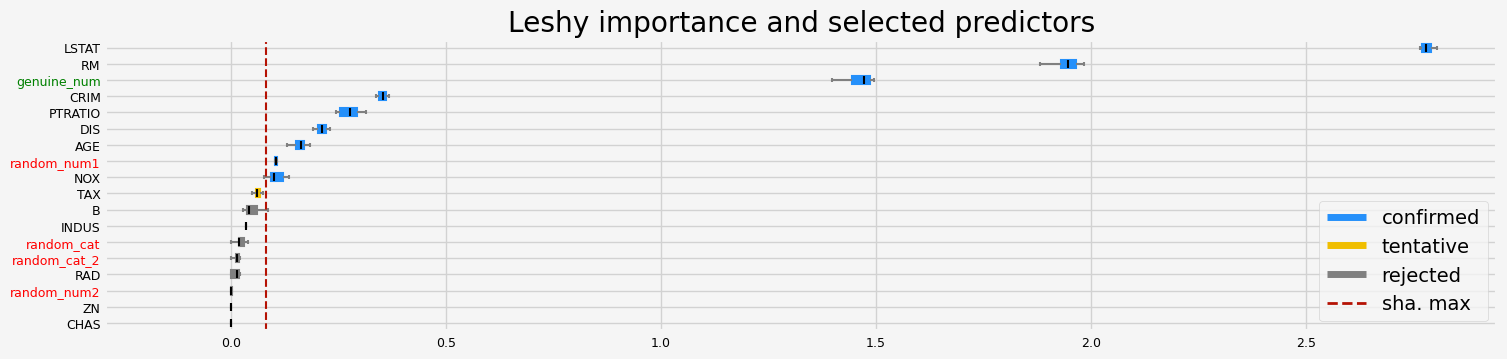

CPU times: user 2.13 s, sys: 218 ms, total: 2.34 s
Wall time: 989 ms


In [10]:
%%time

model = clone(model)

# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

with permutation importance

Leshy iteration:  90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]




Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	1
Rejected: 	9
All relevant predictors selected in 00:00:04.73
The selected features: ['CRIM' 'NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']
The agnostic ranking: [ 1  7  3  7  1  1 11  1  4  1  1  2  1  4  9  6 10  1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'DIS', 'PTRATIO', 'NOX', 'TAX', 'B', 'RAD', 'INDUS', 'random_num1', 'CHAS', 'ZN', 'random_num2', 'AGE', 'random_cat', 'random_cat_2']


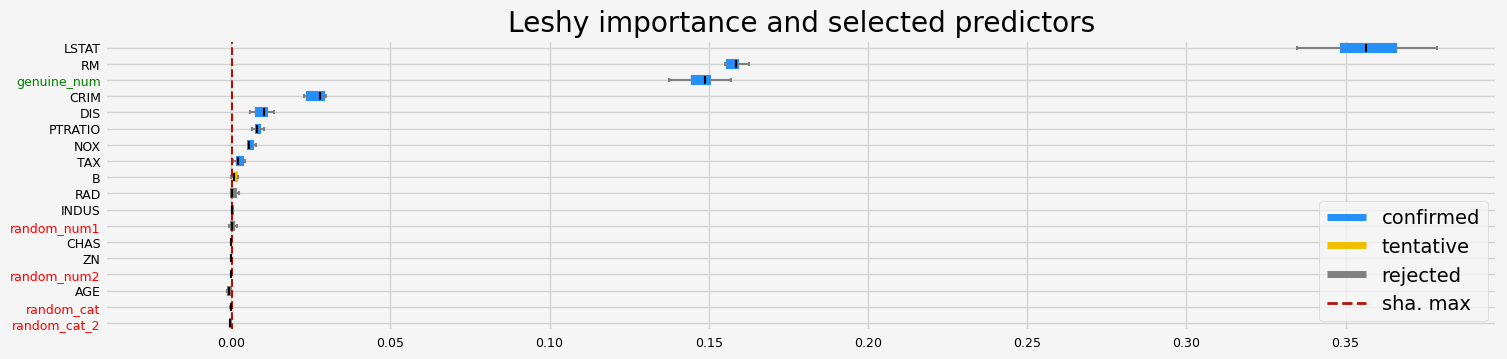

CPU times: user 2.67 s, sys: 412 ms, total: 3.08 s
Wall time: 5.31 s


In [11]:
%%time

model = clone(model)

# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="pimp"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## BoostAGroota

with SHAP importance

BoostaGRoota round:  20%|██        | 2/10 [00:01<00:06,  1.27it/s]


The selected features: ['CRIM' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'random_num1' 'genuine_num']
The agnostic ranking: [2 1 1 1 1 2 2 2 1 1 2 1 2 2 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'PTRATIO', 'DIS', 'AGE', 'random_num1', 'NOX', 'TAX', 'B', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'ZN', 'random_num2', 'CHAS']


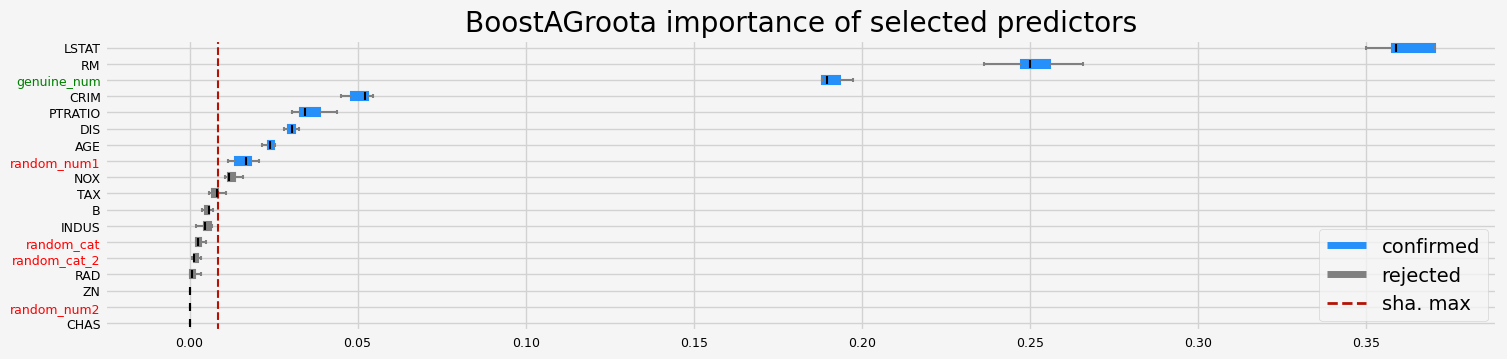

CPU times: user 2.8 s, sys: 475 ms, total: 3.28 s
Wall time: 2.18 s


In [13]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## GrootCV

Repeated k-fold: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 2 2 1 2 1 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'PTRATIO', 'DIS', 'CRIM', 'NOX', 'AGE', 'TAX', 'B', 'random_num1', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'ZN', 'random_num2', 'CHAS']


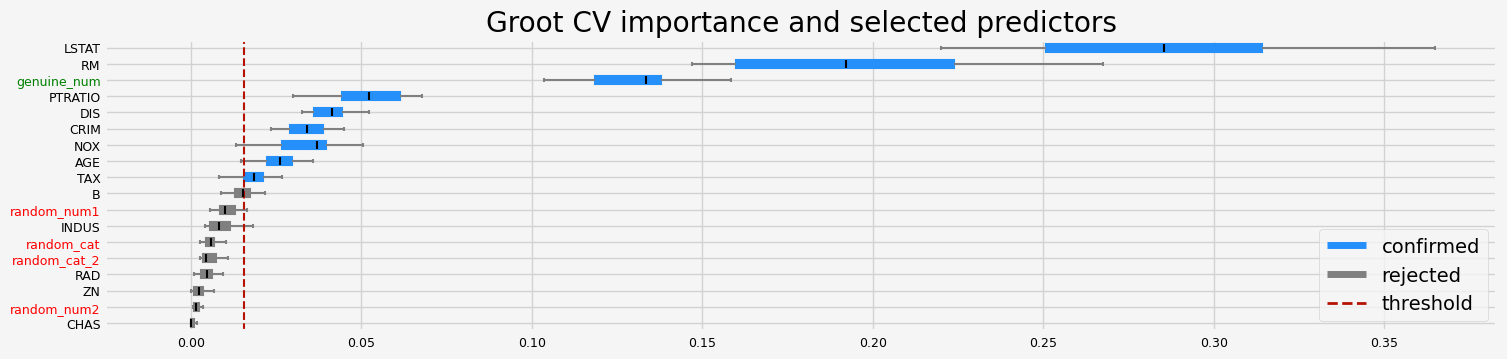

CPU times: user 27.1 s, sys: 2.09 s, total: 29.2 s
Wall time: 12.3 s


In [14]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="rmse", cutoff=1, n_folds=5, n_iter=5, silent=True
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## ARFS in sklearn pipelines

all the selectors (basic, arfs and MRmr) are sklearn compatible and follows the same architecture. Namely, they use the sklearn relevant base classes and therefore have the same methods.

In [15]:
feat_selector = arfsgroot.GrootCV(
    objective="rmse", cutoff=1, n_folds=5, n_iter=5, silent=True
)

arfs_fs_pipeline = Pipeline(
    [
        ("missing", MissingValueThreshold(threshold=0.05)),
        ("unique", UniqueValuesThreshold(threshold=1)),
        ("collinearity", CollinearityThreshold(threshold=0.85)),
        ("arfs", feat_selector),
    ]
)

X_trans = arfs_fs_pipeline.fit(X=X, y=y).transform(X=X)

Repeated k-fold: 100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


you can access the attributes of a step as you would in any sklearn pipeline

In [17]:
arfs_fs_pipeline.named_steps["collinearity"].get_feature_names_out()

array(['INDUS', 'CHAS', 'RM', 'RAD', 'PTRATIO', 'random_num1',
       'random_num2', 'random_cat', 'random_cat_2', 'genuine_num'],
      dtype=object)

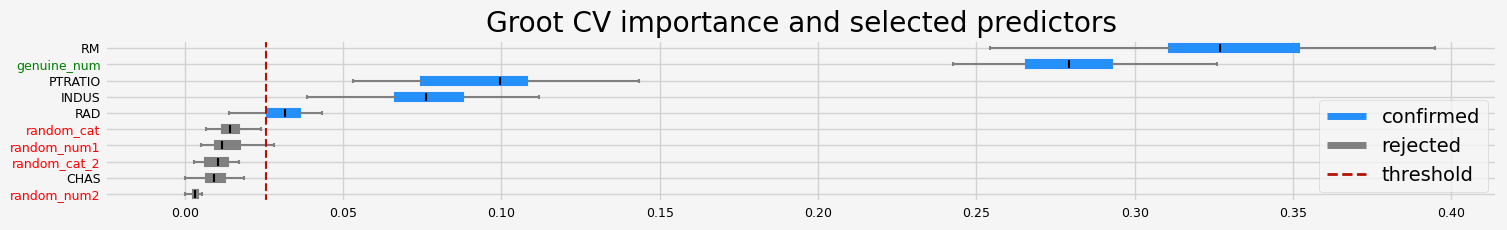

In [18]:
fig = arfs_fs_pipeline.named_steps["arfs"].plot_importance()
# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [19]:
make_fs_summary(arfs_fs_pipeline)

,predictor,missing,unique,collinearity,arfs
0,CRIM,1,1,0,nan
1,ZN,1,1,0,nan
2,INDUS,1,1,1,1
3,CHAS,1,1,1,0
4,NOX,1,1,0,nan
5,RM,1,1,1,1
6,AGE,1,1,0,nan
7,DIS,1,1,0,nan
8,RAD,1,1,1,1
9,TAX,1,1,0,nan


## Testing and comparing Leshy, GrootCV and BoostAGroota 

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.

==================== Benchmarking using sklearn permutation importance ====================


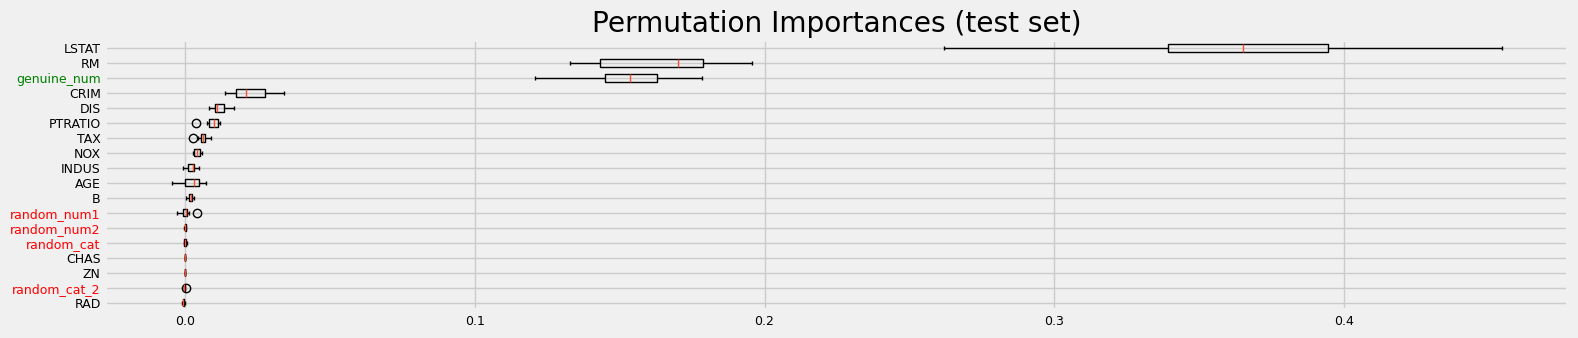

CPU times: user 838 ms, sys: 223 ms, total: 1.06 s
Wall time: 938 ms


In [21]:
%%time
model = clone(model)
# Benchmark with scikit-learn permutation importance
print("=" * 20 + " Benchmarking using sklearn permutation importance " + "=" * 20)
fig = sklearn_pimp_bench(model, X, y, task="regression", sample_weight=None)

### Testing Leshy

Leshy seems to struggle with catboost, for regression and this particular data set whereas the other ARFS methods seem OK. To be investigated.

==================== Leshy - testing:     RandomForestRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:16<00:01,  1.83s/it]




Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:16.49
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'random_num1'
 'genuine_num']


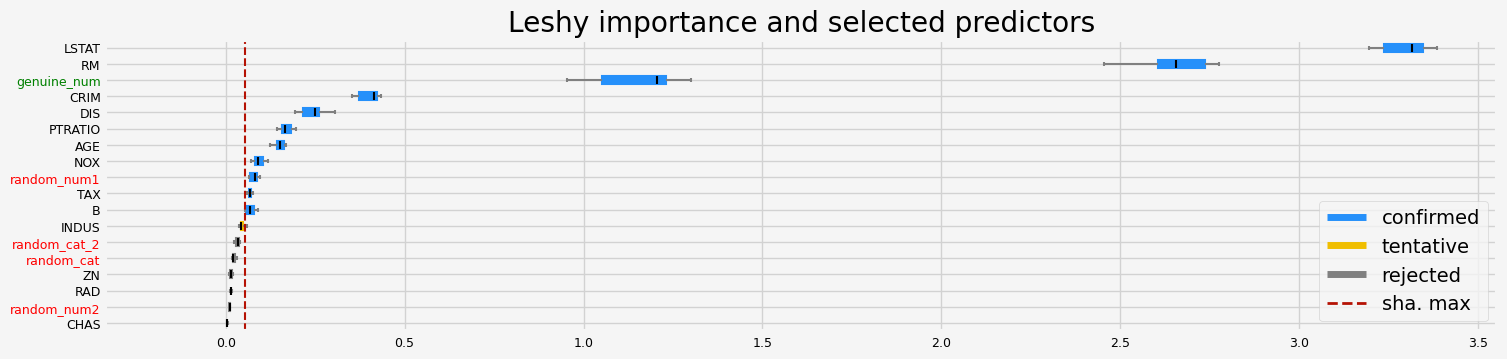

==================== Leshy - testing:     RandomForestRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:26<00:02,  2.94s/it]




Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	1
Rejected: 	7
All relevant predictors selected in 00:00:26.51
['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT'
 'genuine_num']


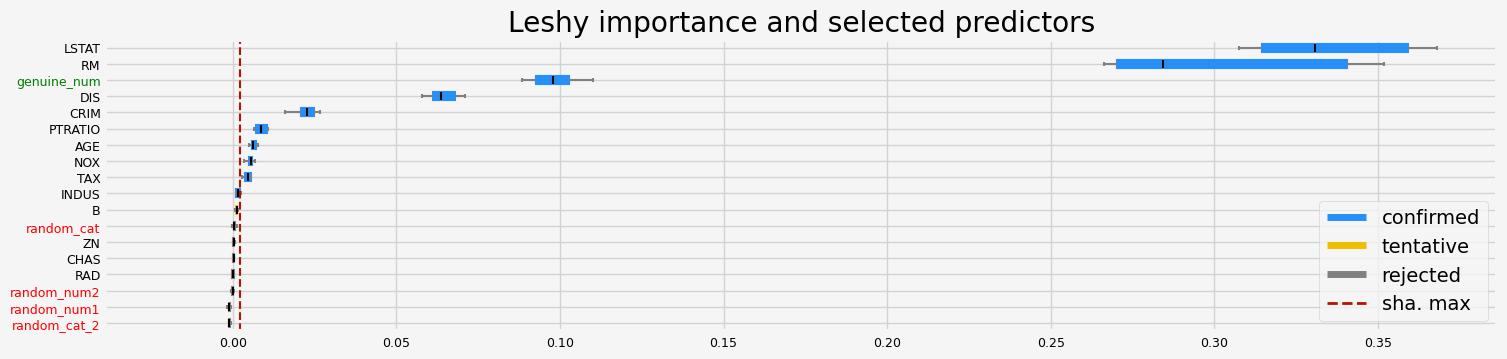

==================== Leshy - testing:     RandomForestRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:05<00:00,  1.69it/s]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	8
All relevant predictors selected in 00:00:05.34
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


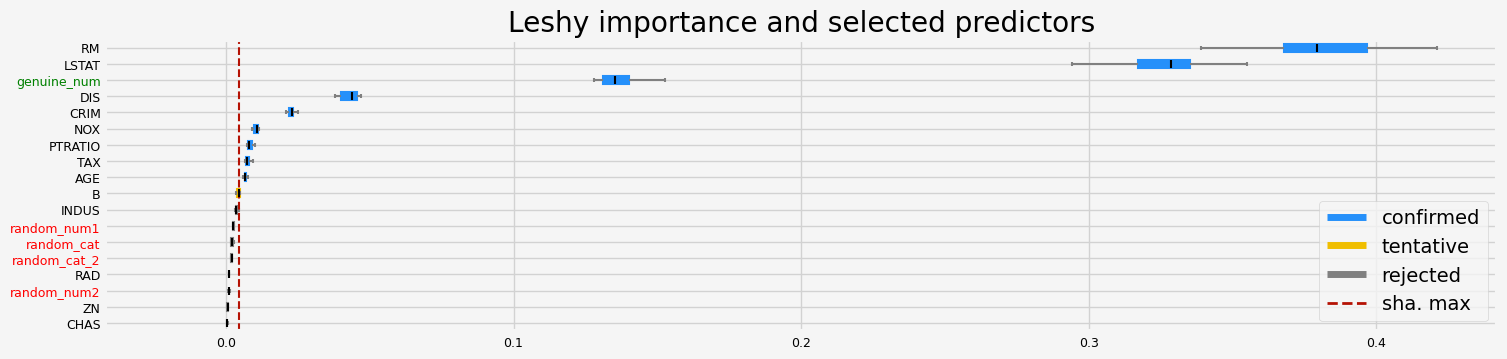

==================== Leshy - testing:         CatBoostRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]




Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	6
Tentative: 	6
Rejected: 	6
All relevant predictors selected in 00:00:05.16
['RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


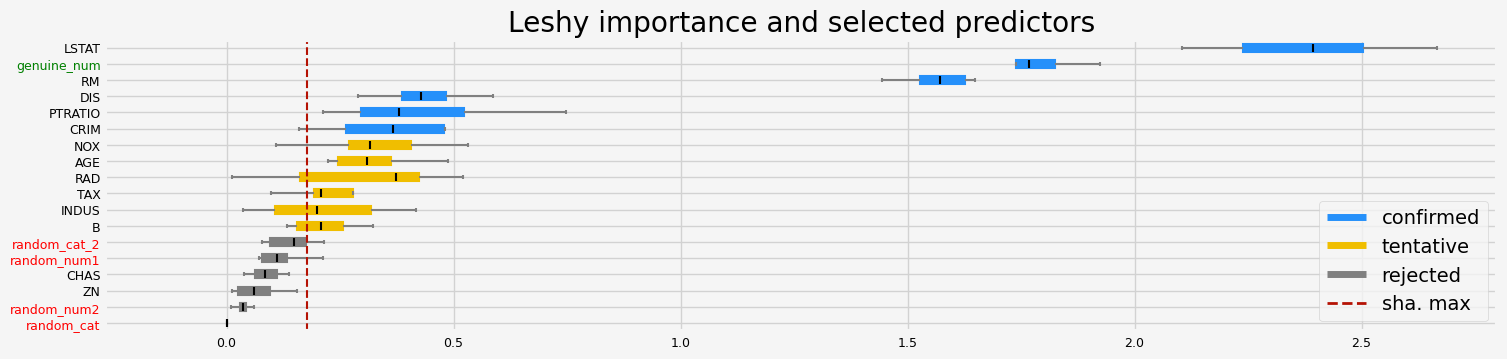

==================== Leshy - testing:         CatBoostRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:10<00:01,  1.16s/it]




Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	6
Tentative: 	6
Rejected: 	6
All relevant predictors selected in 00:00:10.42
['CRIM' 'RM' 'DIS' 'TAX' 'LSTAT' 'genuine_num']


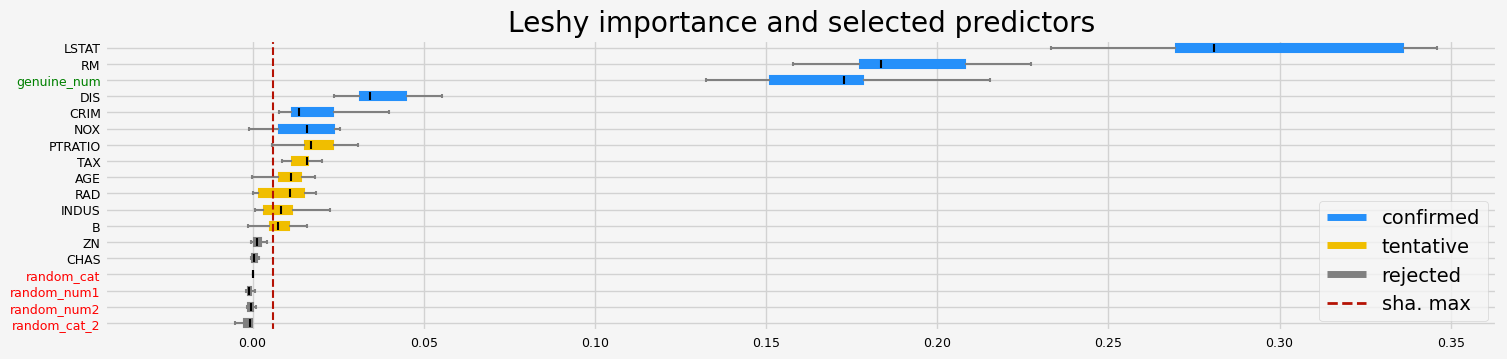

==================== Leshy - testing:         CatBoostRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	4
Rejected: 	7
All relevant predictors selected in 00:00:05.07
['CRIM' 'NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


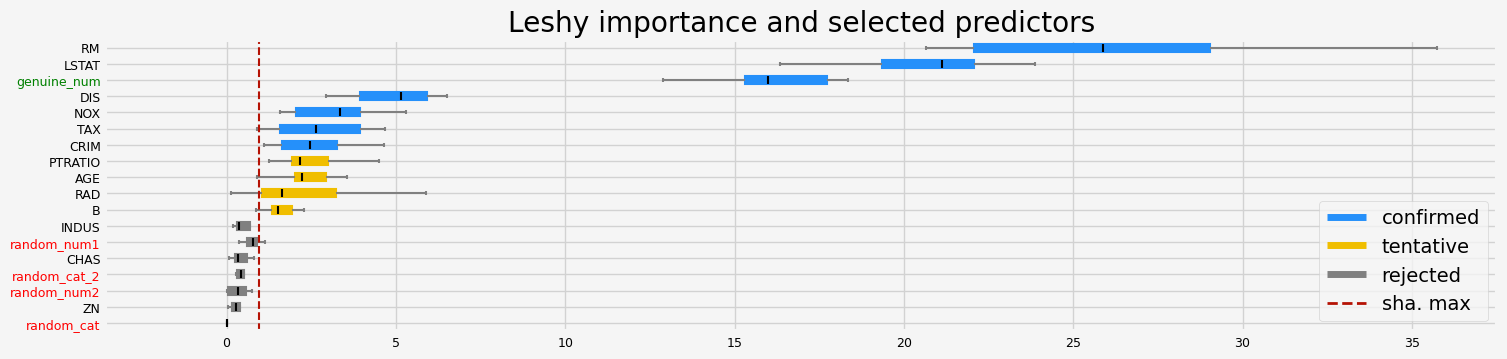

==================== Leshy - testing:              XGBRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:07<00:00,  1.27it/s]




Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	3
Rejected: 	6
All relevant predictors selected in 00:00:07.09
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


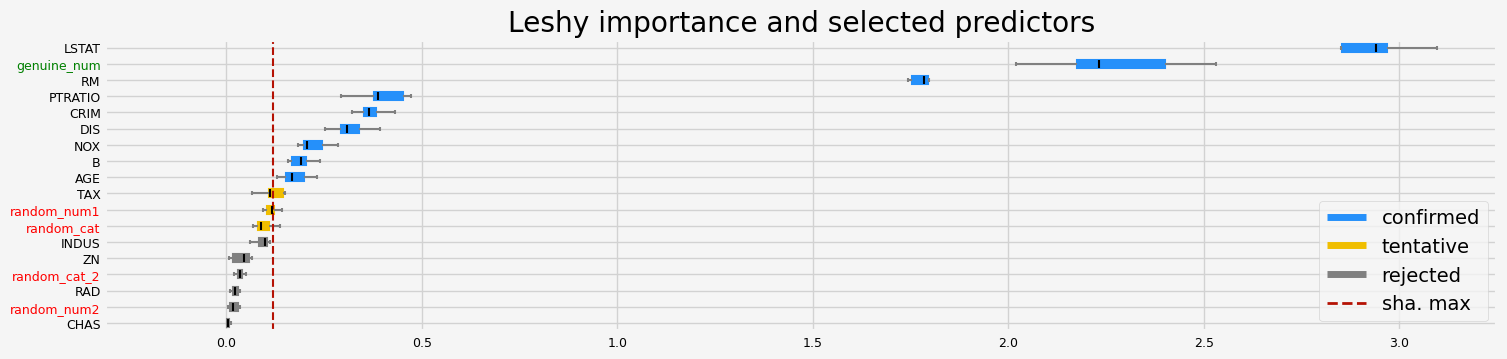

==================== Leshy - testing:              XGBRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]




Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	4
Rejected: 	6
All relevant predictors selected in 00:00:06.34
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


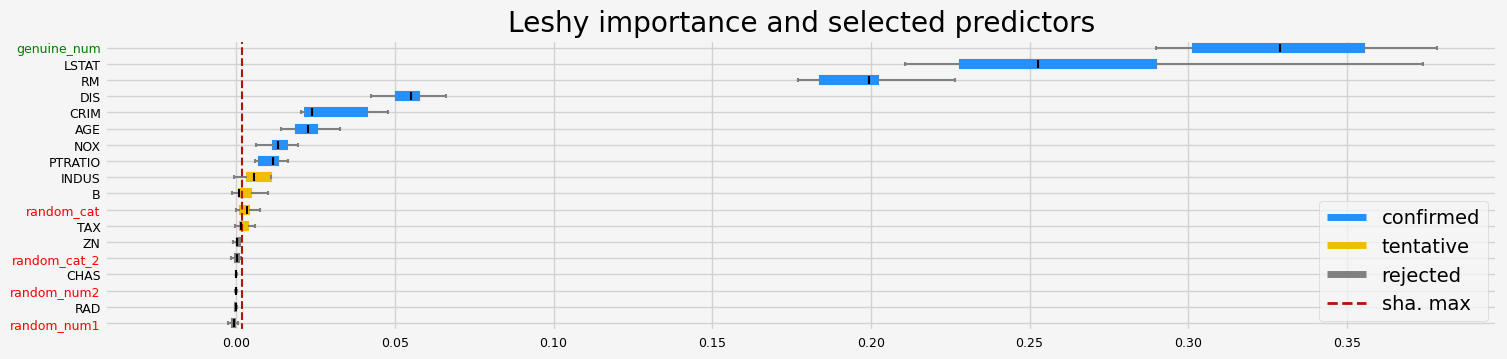

==================== Leshy - testing:              XGBRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:02<00:00,  3.16it/s]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:02.86
['CRIM' 'NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


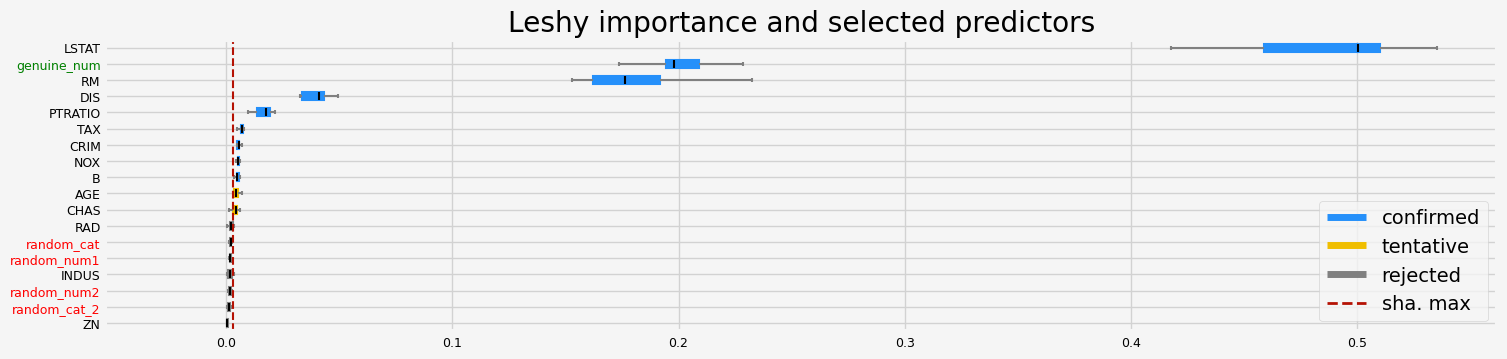

==================== Leshy - testing:             LGBMRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  6.90it/s]




Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	0
Rejected: 	10
All relevant predictors selected in 00:00:01.32
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


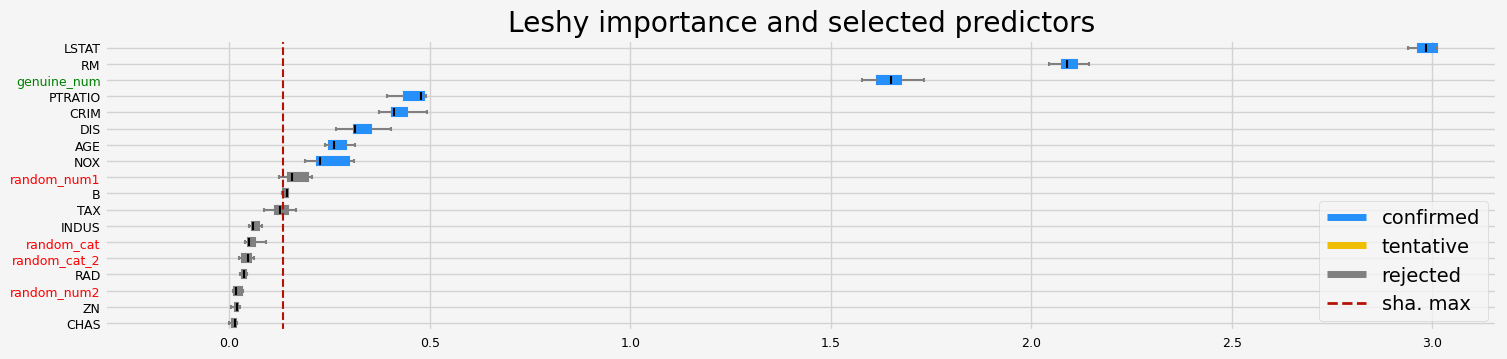

==================== Leshy - testing:             LGBMRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:05<00:00,  1.74it/s]




Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	3
Rejected: 	7
All relevant predictors selected in 00:00:05.17
['CRIM' 'NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


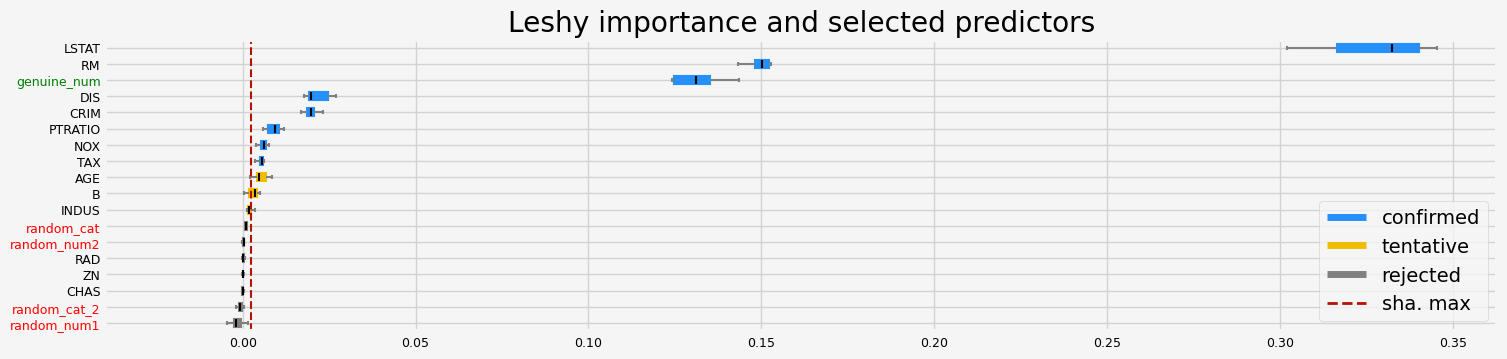

==================== Leshy - testing:             LGBMRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  4.57it/s]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	3
Rejected: 	10
All relevant predictors selected in 00:00:01.98
['CRIM' 'RM' 'DIS' 'LSTAT' 'genuine_num']


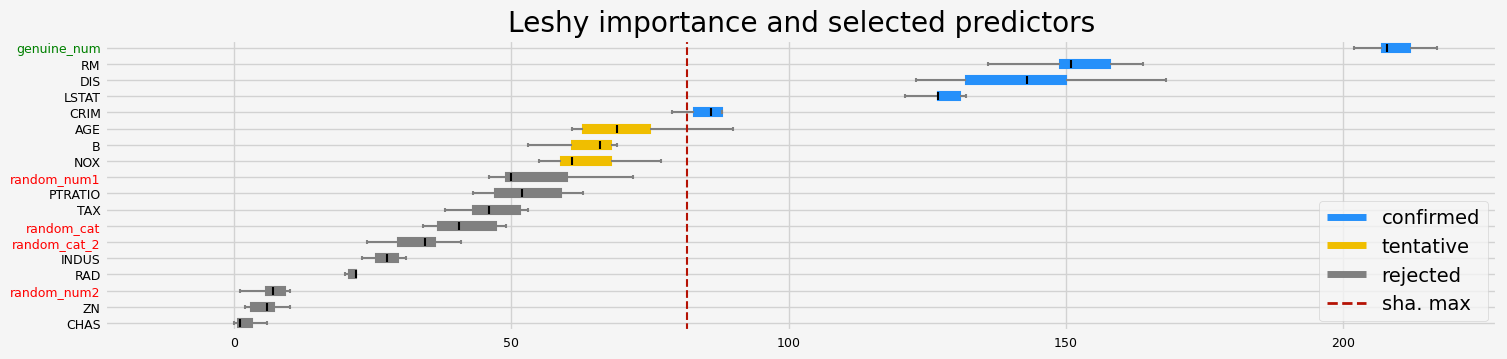

==================== Leshy - testing:             LGBMRegressor for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:00<00:00, 12.03it/s]




Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:00.76
['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


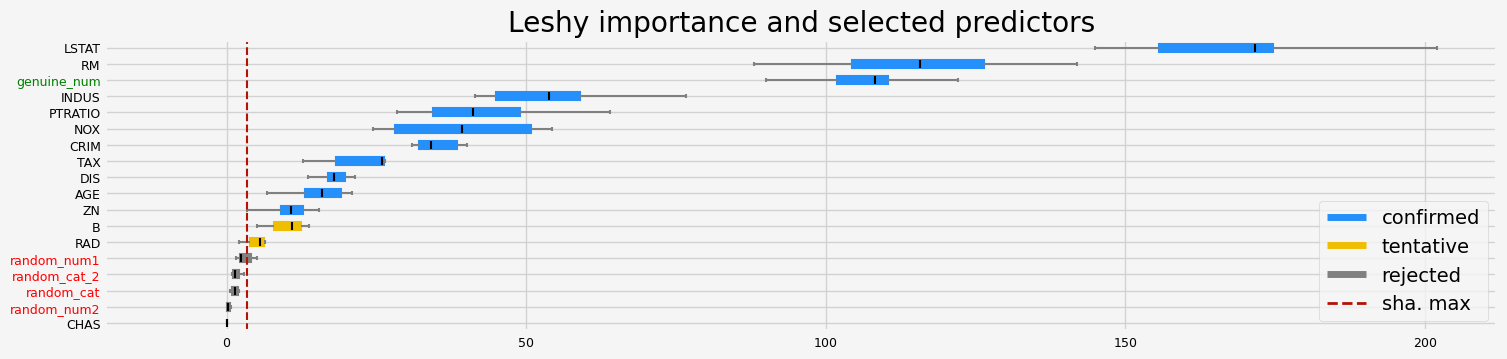

==================== Leshy - testing:             LGBMRegressor for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:03<00:00,  2.47it/s]




Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	1
Rejected: 	7
All relevant predictors selected in 00:00:03.66
['CRIM' 'ZN' 'INDUS' 'NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT'
 'genuine_num']


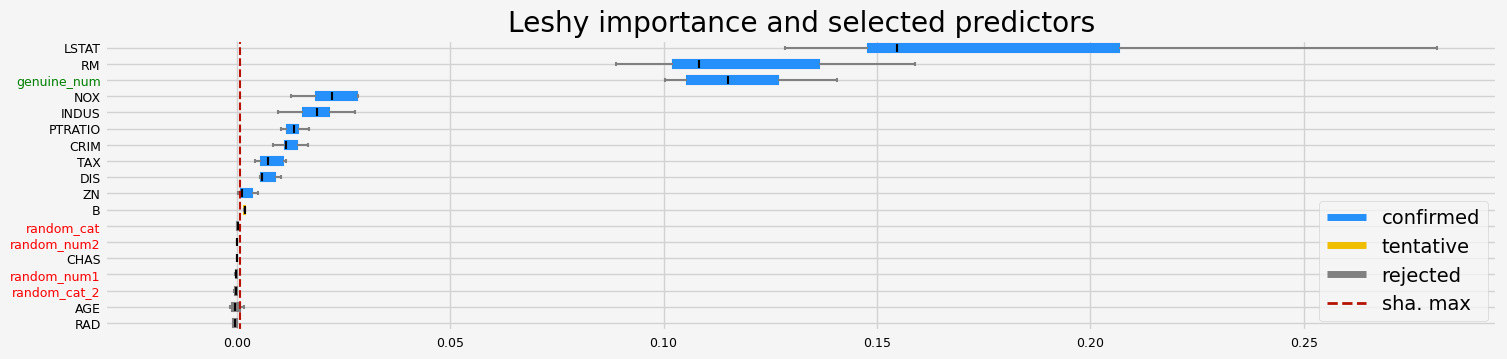

==================== Leshy - testing:             LGBMRegressor for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:00<00:00, 10.66it/s]




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	0
Rejected: 	7
All relevant predictors selected in 00:00:00.86
['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


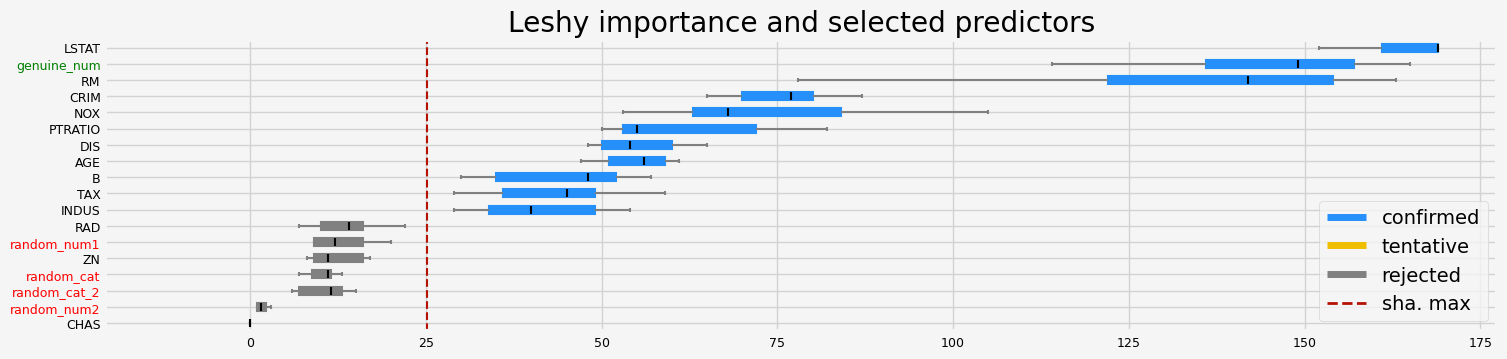

In [22]:
models = [
    RandomForestRegressor(n_jobs=4, oob_score=True),
    CatBoostRegressor(random_state=42, verbose=0),
    XGBRegressor(random_state=42, verbosity=0),
    LGBMRegressor(random_state=42, verbose=-1),
    LightForestRegressor(n_feat=X.shape[1]),
]

feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42
)

if __name__ == "__main__":
    # regression
    boston = load_data(name="Boston")
    X, y = boston.data, boston.target
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

### Testing GrootCV

Repeated k-fold: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


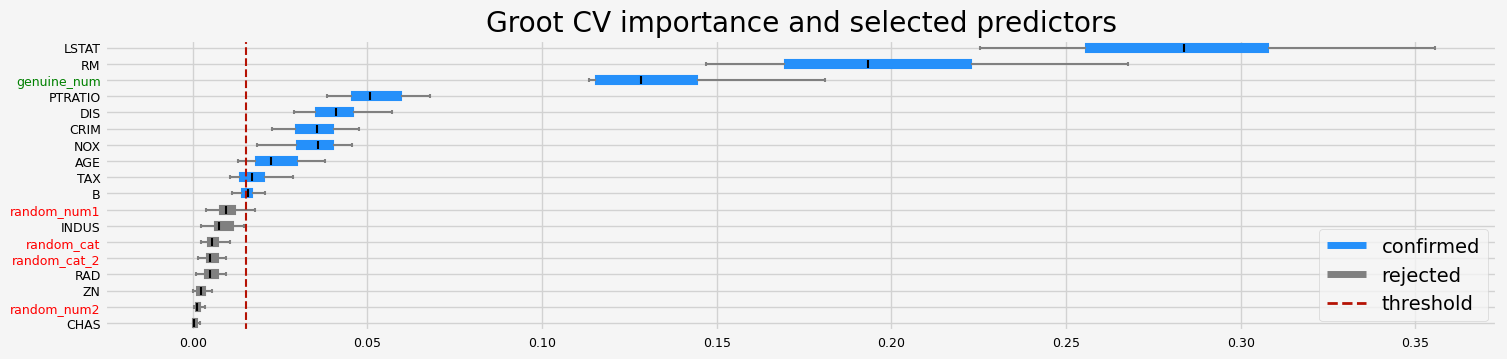

In [23]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective="rmse"):
    feat_selector = arfsgroot.GrootCV(
        objective=objective, cutoff=1, n_folds=5, n_iter=5
    )
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.get_feature_names_out())
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match="random")
    fig = highlight_tick(figure=fig, str_match="genuine", color="green")
    plt.show()
    gc.enable()
    del feat_selector
    gc.collect()


if __name__ == "__main__":
    # regression
    boston = load_data(name="Boston")
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    testing_estimators(X=X, y=y, objective="rmse")

### Testing BoostAGroota

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:34<05:06, 34.11s/it]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'random_num1'
 'genuine_num']


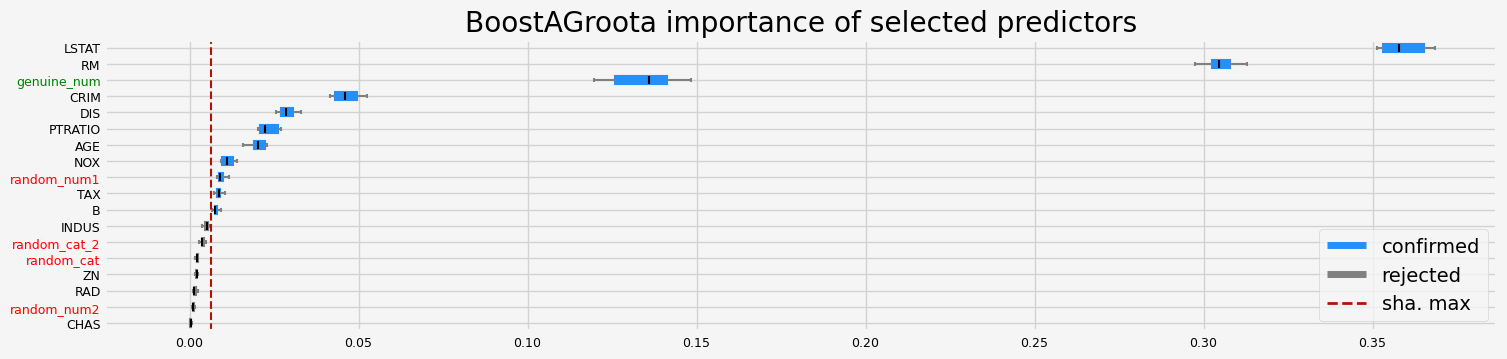

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: pimp            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:58<03:55, 29.46s/it]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


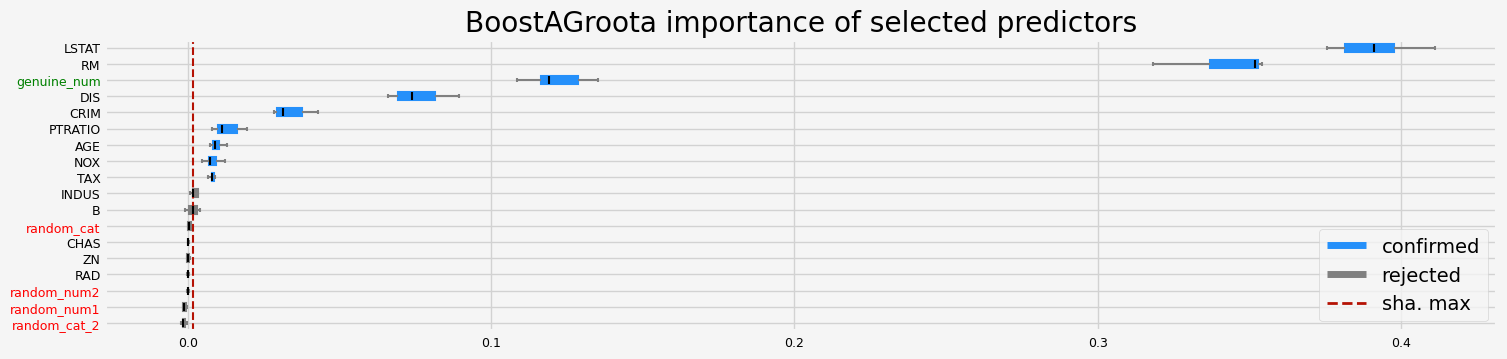

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [00:10<01:35, 10.59s/it]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


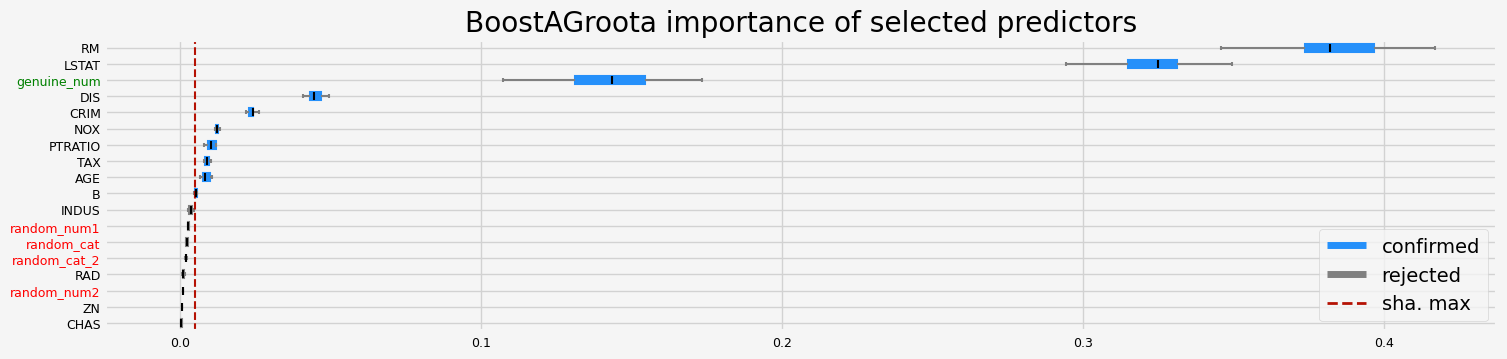

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█         | 1/10 [01:41<15:09, 101.06s/it]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


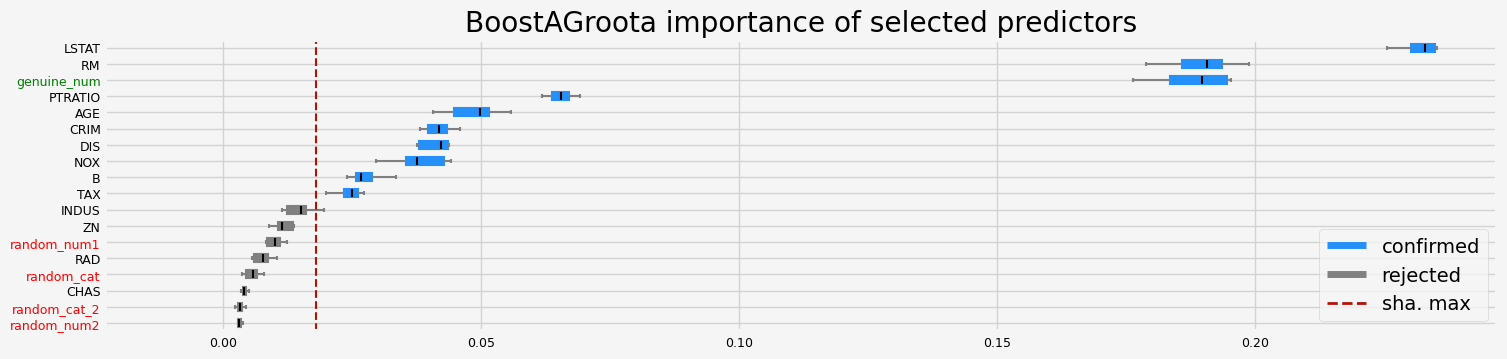

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█         | 1/10 [01:24<12:44, 84.96s/it]


['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


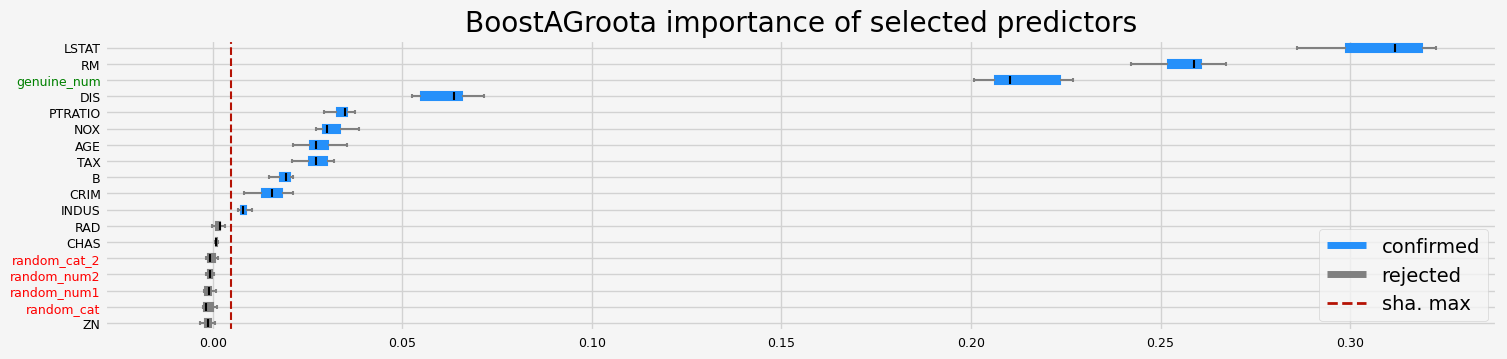

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [01:12<10:55, 72.85s/it]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


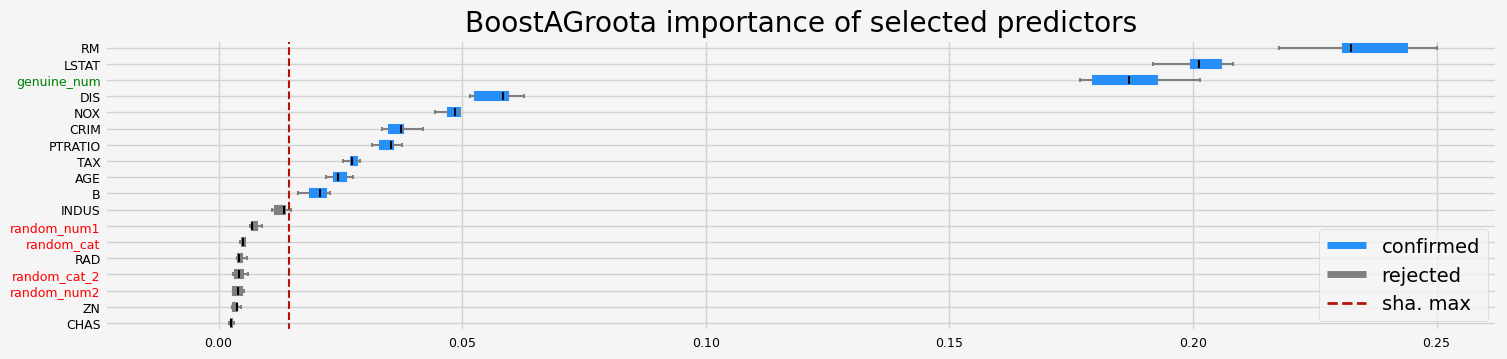

==================== BoostAGroota - testing:              XGBRegressor for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
BoostaGRoota round:  10%|█         | 1/10 [00:04<00:39,  4.40s/it]ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


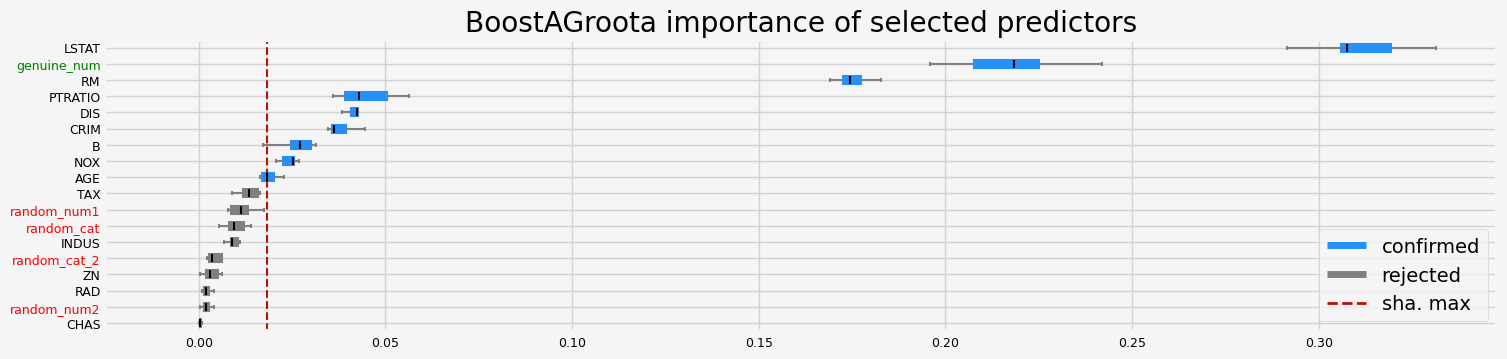

==================== BoostAGroota - testing:              XGBRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:11<01:45, 11.76s/it]


['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


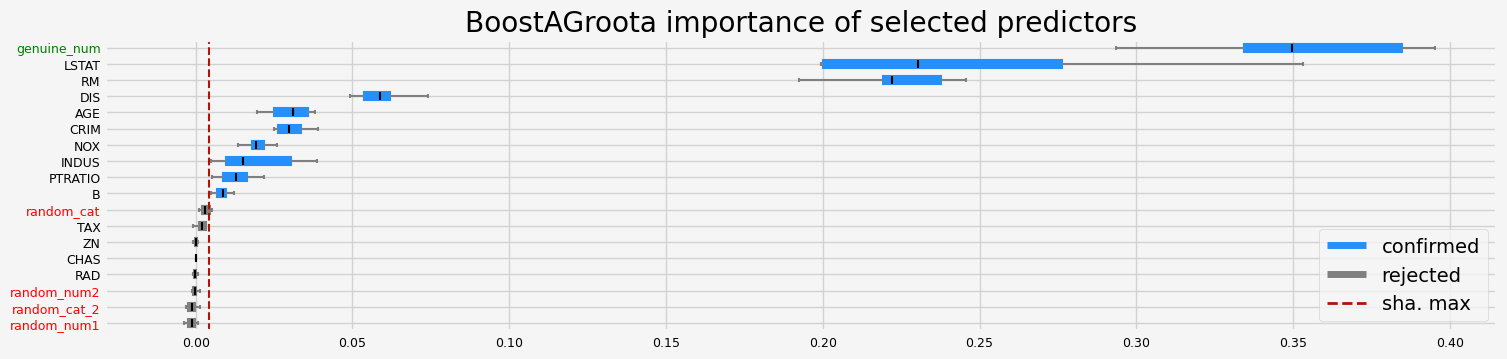

==================== BoostAGroota - testing:              XGBRegressor for var.imp: native          ====================


BoostaGRoota round:  20%|██        | 2/10 [00:07<00:30,  3.86s/it]


['CRIM' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


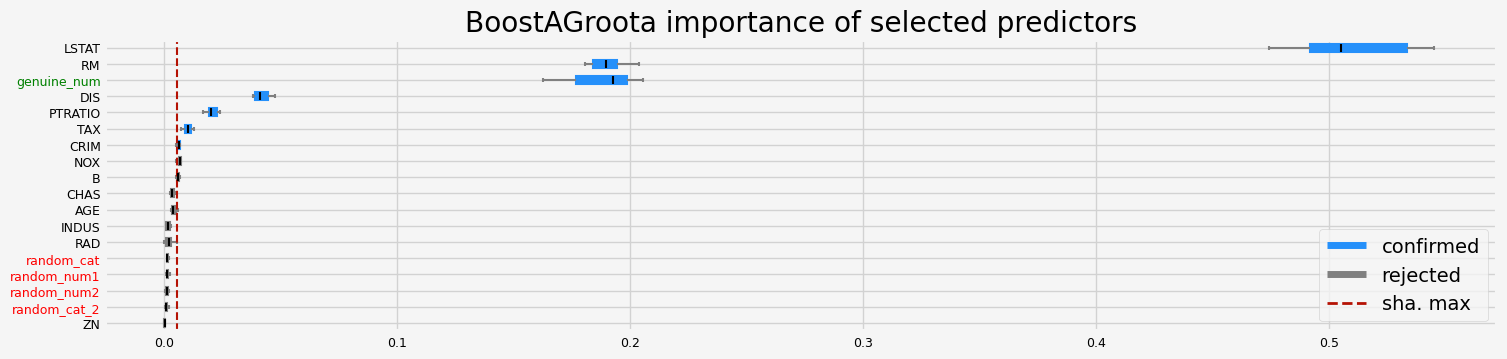

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: shap            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:02<00:20,  2.23s/it]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


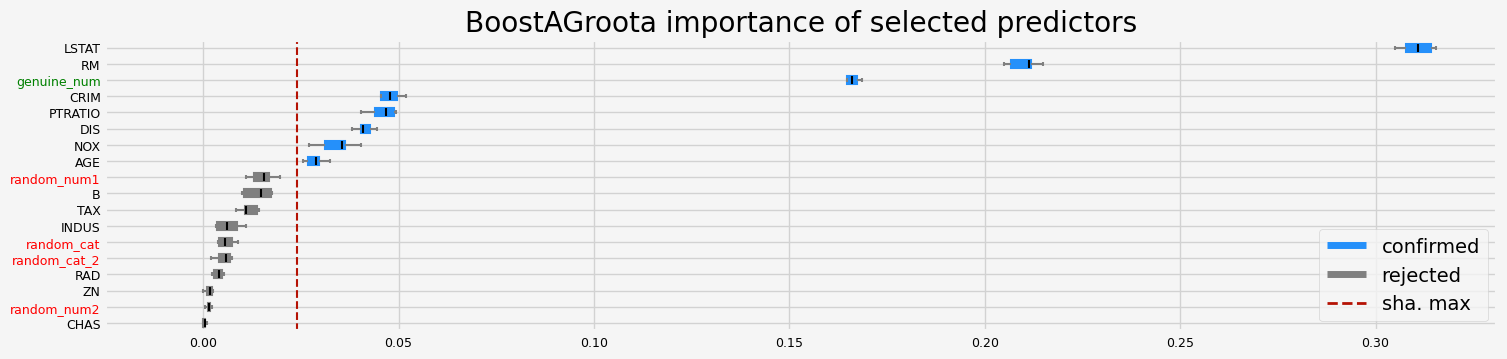

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:08<01:13,  8.22s/it]


['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


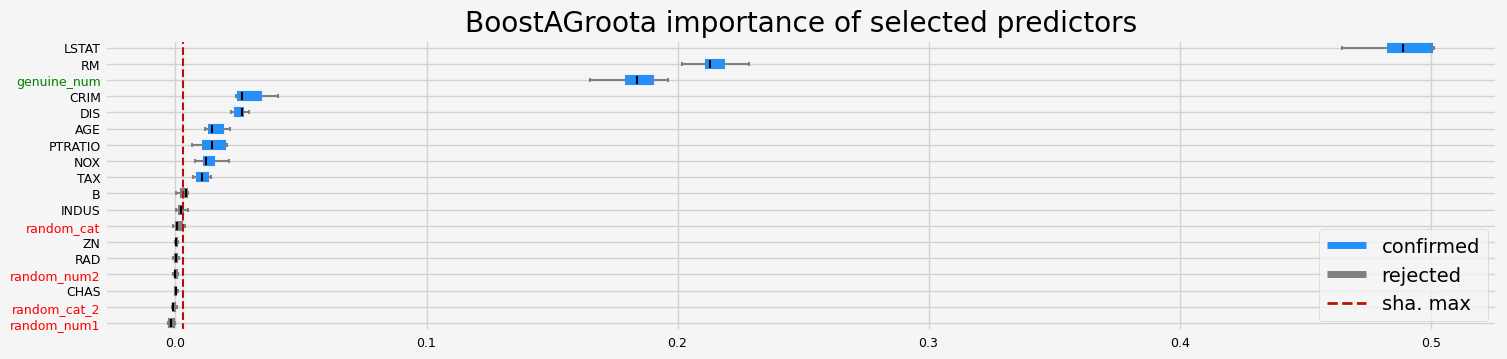

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [00:02<00:20,  2.28s/it]


['CRIM' 'RM' 'AGE' 'DIS' 'LSTAT' 'genuine_num']


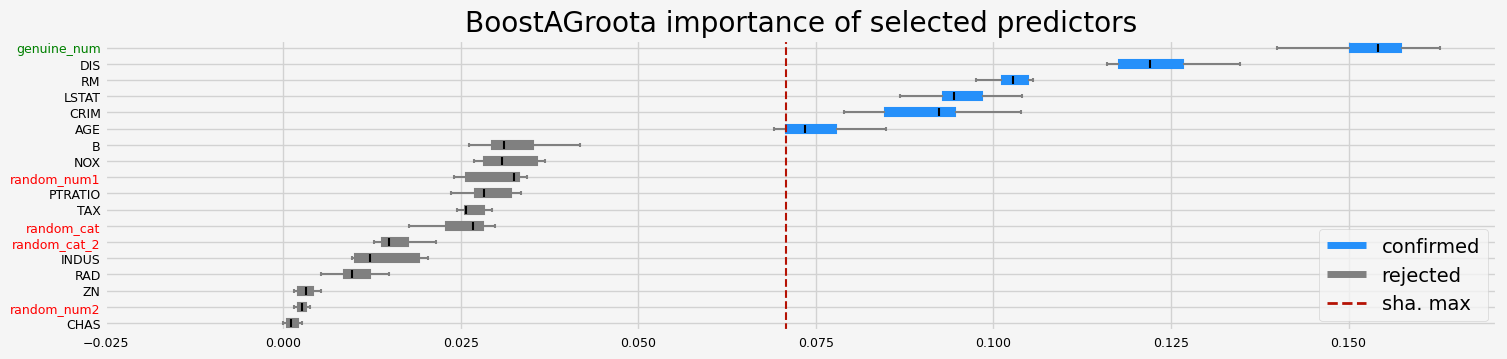

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: shap            ====================


BoostaGRoota round:  30%|███       | 3/10 [00:00<00:01,  3.87it/s]


['CRIM' 'INDUS' 'RM' 'LSTAT' 'genuine_num']


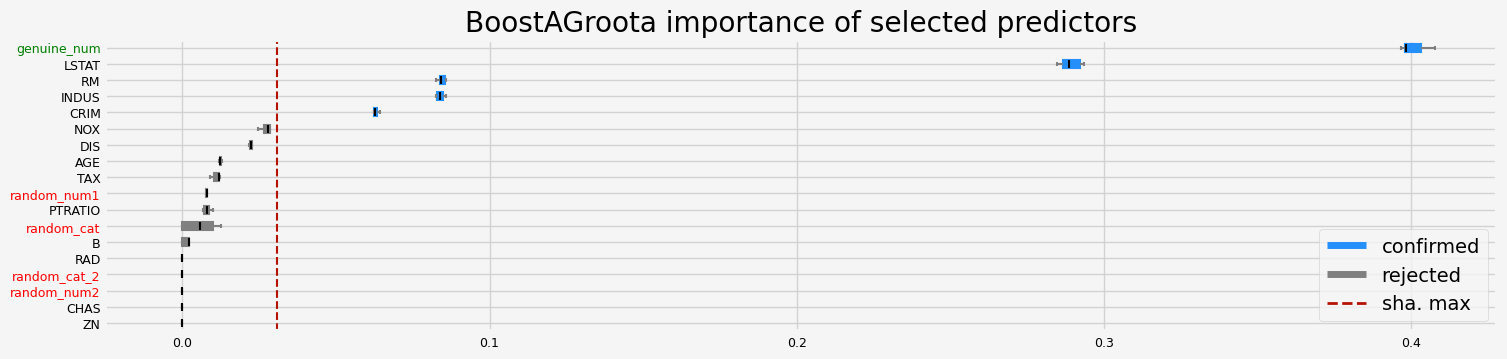

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: pimp            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:04<00:37,  4.12s/it]


['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'LSTAT' 'genuine_num']


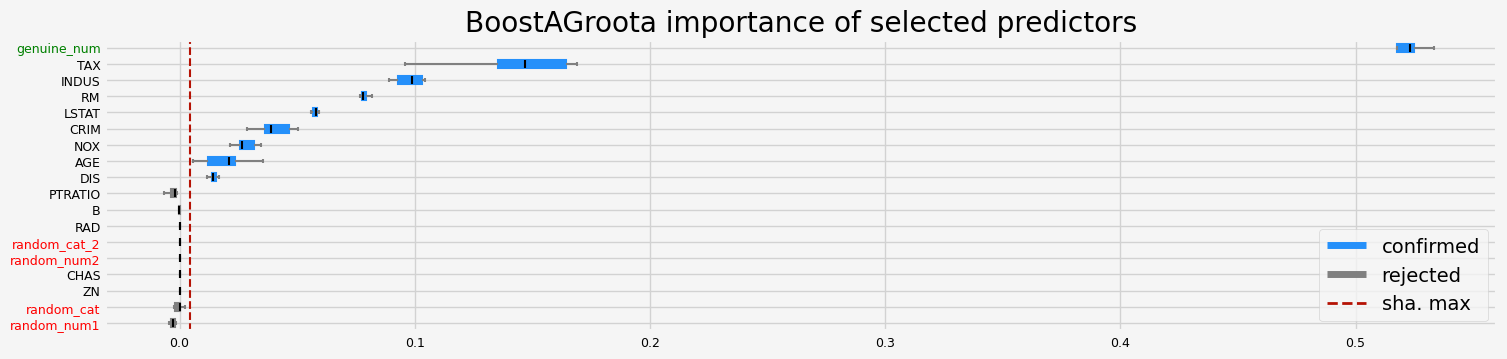

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: native          ====================


BoostaGRoota round:  60%|██████    | 6/10 [00:01<00:00,  4.57it/s]


['CRIM']


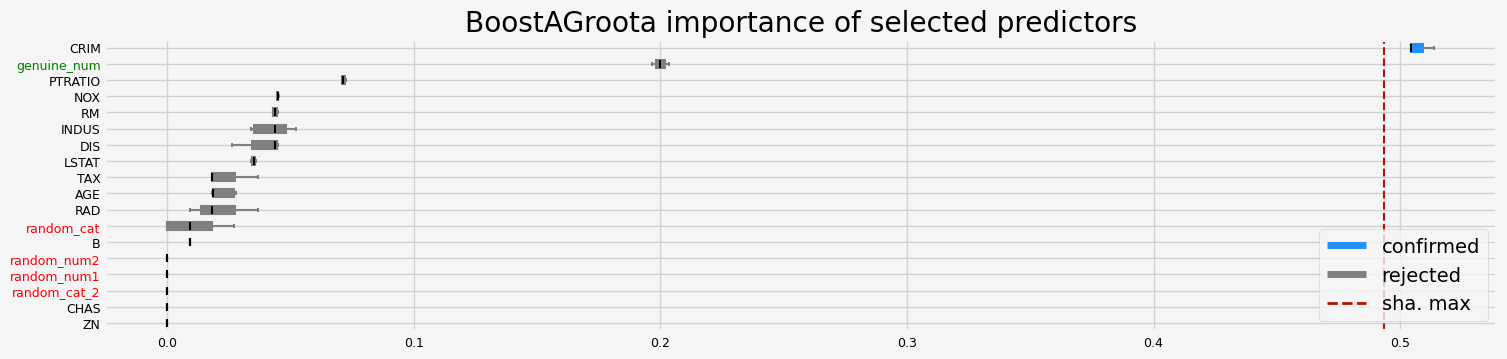

In [25]:
models = [
    RandomForestRegressor(n_jobs=4, oob_score=True),
    CatBoostRegressor(random_state=42, verbose=0),
    XGBRegressor(random_state=42, verbosity=0),
    LGBMRegressor(random_state=42, verbose=-1),
    LightForestRegressor(n_feat=X.shape[1]),
]

feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1
)

if __name__ == "__main__":
    # regression
    boston = load_data(name="Boston")
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)